<a href="https://colab.research.google.com/github/427paul/Machine_Learning/blob/main/DL_3_3_%EB%8B%A4%EC%A4%91%EB%B6%84%EB%A5%98_%EB%AA%A8%EB%8D%B8%EB%A7%81_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Multi-Class : MNIST**


## **1.환경준비**

### (1) 라이브러리 Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
np.set_printoptions(linewidth=np.inf)

from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam
from torchvision import datasets
from torchvision.transforms import ToTensor
torch.set_printoptions(linewidth=1000)

### (2) 필요 함수 생성

* 딥러닝을 위한 데이터로더 만들기

In [3]:
def make_DataSet(x_train, x_val, y_train, y_val, batch_size = 32) :

    # 데이터 텐서로 변환
    x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)  # long = int64
    x_val_tensor = torch.tensor(x_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.long)

    # TensorDataset 생성 : 텐서 데이터셋으로 합치기
    train_dataset = TensorDataset(x_train_tensor, y_train_tensor)

    # DataLoader 생성
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle = True)

    return train_loader, x_val_tensor, y_val_tensor

* 학습을 위한 함수

In [4]:
def train(dataloader, model, loss_fn, optimizer, device):
    size = len(dataloader.dataset)                  # 전체 데이터셋의 크기
    num_batches = len(dataloader)                   # 배치 크기
    tr_loss = 0
    model.train()                                   # 훈련 모드로 설정(드롭아웃 및 배치 정규화와 같은 계층을 훈련 모드로 변경)
    for batch, (X, y) in enumerate(dataloader):     # batch : 현재 배치 번호, (X, y) : 입력 데이터와 레이블
        X, y = X.to(device), y.to(device)           # X.to(device), y.to(device): 입력 데이터와 레이블을 지정된 장치(device, CPU 또는 GPU)로 이동

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        tr_loss += loss

        # Backpropagation
        loss.backward()             # 역전파를 통해 모델의 각 파라미터에 대한 손실의 기울기를 계산
        optimizer.step()            # 옵티마이저가 계산된 기울기를 사용하여 모델의 파라미터를 업데이트
        optimizer.zero_grad()       # 옵티마이저의 기울기 값 초기화. 기울기가 누적되는 것 방지

    tr_loss /= num_batches          # 모든 배치에서의 loss 평균

    return tr_loss.item()

* 검증을 위한 함수

In [5]:
def evaluate(x_val_tensor, y_val_tensor, model, loss_fn, device):
    model.eval()                        # 모델을 평가 모드로 설정

    with torch.no_grad():               # 평가 과정에서 기울기를 계산하지 않도록 설정(메모리 사용을 줄이고 평가 속도를 높입니다.)
        x, y = x_val_tensor.to(device), y_val_tensor.to(device)
        pred = model(x)
        eval_loss = loss_fn(pred, y).item()    # 예측 값 pred와 실제 값 y 사이의 손실 계산

    return eval_loss, pred

* 학습곡선

In [6]:
def dl_learning_curve(tr_loss_list, val_loss_list):

    epochs = list(range(1, len(tr_loss_list)+1))
    plt.plot(epochs, tr_loss_list, label='train_err', marker = '.')
    plt.plot(epochs, val_loss_list, label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

### (3) device 준비(cpu or gpu)

In [7]:
# cpu 혹은 gpu 사용
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


### (4) 데이터 셋

#### 1) 다운로드

In [8]:
# Download training data from open datasets.
train_dataset = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),   # 픽셀값을 [0,1] 사이로 정규화하고 텐서로 변환
)

# Download test data from open datasets.
test_dataset = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.09MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.26MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.8MB/s]


#### 2) 데이터셋 정보

* 데이터셋 일반 정보

In [9]:
train_dataset, test_dataset

(Dataset MNIST
     Number of datapoints: 60000
     Root location: data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset MNIST
     Number of datapoints: 10000
     Root location: data
     Split: Test
     StandardTransform
 Transform: ToTensor())

* 데이터셋의 x와 y

In [10]:
train_dataset.data.shape, train_dataset.targets.shape

(torch.Size([60000, 28, 28]), torch.Size([60000]))

* y(target)의 클래스

In [11]:
train_dataset.classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

* 데이터 1건

In [12]:
train_dataset[0]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.000

* 데이터 이미지 확인

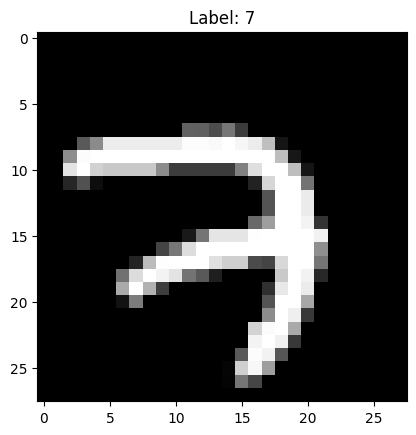

In [13]:
n = 5000
image, label = train_dataset.data[n], train_dataset.targets[n]

# 이미지 시각화
plt.imshow(image, cmap="gray")
plt.title(f"Label: {label}")
plt.show()

## **2.데이터 준비**

* 다운 받은 데이터셋은 다음의 전처리가 완료됨
    * x, y가 분리
    * train, test 분리
    * 스케일링

### (1) train은 데이터로더로 생성

In [14]:
batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)

In [15]:
# 첫번째 배치만 로딩해서 살펴보기
for X, y in train_dataloader:
    print(f"Shape of X [batch, channels, height, width]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [batch, channels, height, width]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


### (2) validation, test 준비
* 데이터셋 분할
    * validation : 학습시, 에포크마다 성능 검증용
    * test : 모델 생성 후 최종 검증용
* dataset의 data 속성으로 데이터를 뽑으면 원본데이터가 나옵니다.
    * 스케일링 안된 데이터
    * 5000, 28, 28 : 3차원 데이터셋
* 그래서 모델링에 사용하려면 두가지 전처리를 다시 해줘야 함
    * 스케일링 : 원본데이터가 0~255 까지 숫자이므로, 255로 나눠주면 됨
    * 4차원 변환 : 5000, 1, 28, 28

#### 1) 데이터 분할 : test --> val, test

In [16]:
x_val, x_test = test_dataset.data[:5000], test_dataset.data[5000:]
y_val, y_test = test_dataset.targets[:5000], test_dataset.targets[5000:]

In [17]:
x_val.shape, y_val.shape

(torch.Size([5000, 28, 28]), torch.Size([5000]))

#### 2) 스케일링

In [18]:
x_val = x_val / 255
x_test = x_test/ 255

#### 3) 3차원 데이터셋 --> 4차원 데이터셋
* 여기서 꼭 필요한 작업은 아닙니다.
* 하지만, 잠시 후에 배울 CNN 모델링에서...
    * 이미지 한장의 구조는, [채널, 세로픽셀 수, 가로픽셀 수] 입니다.
        * 채널 : 흑백 = 1, 컬러 = 3
* 그러므로 여기서도 동일한 전처리를 수행합니다.

In [20]:
x_val = x_val.view(5000, 1, 28, 28)  # [1 * 28 * 28 이미지 5000장] 구조로 변환.
x_test = x_test.view(5000, 1, 28, 28) # reshape와 같은 기능

print(x_val.shape, x_test.shape)

torch.Size([5000, 1, 28, 28]) torch.Size([5000, 1, 28, 28])


## **3.모델링1**

### (1) 모델 선언

In [21]:
n_feature = 28 * 28
n_class = 10

# 모델 구조 설계
model = nn.Sequential(nn.Flatten(),               # 이미지를 옆으로 펼치기(한 행에 데이터를 넣기)
                      nn.Linear(28*28, n_class)
        ).to(device)

print(model)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=10, bias=True)
)


* Loss function과 Optimizer

In [22]:
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

### (2) 학습

In [23]:
epochs = 10
tr_loss_list, val_loss_list = [], []

for t in range(epochs):
    tr_loss = train(train_dataloader, model, loss_fn, optimizer, device)
    val_loss,_ = evaluate(x_val, y_val, model, loss_fn, device)

    # 리스트에 loss 추가 --> learning curve 그리기 위해.
    tr_loss_list.append(tr_loss)
    val_loss_list.append(val_loss)

    print(f"Epoch {t+1}, train loss : {tr_loss:4f}, val loss : {val_loss:4f}")

Epoch 1, train loss : 0.549344, val loss : 0.427626
Epoch 2, train loss : 0.328886, val loss : 0.378540
Epoch 3, train loss : 0.299956, val loss : 0.360350
Epoch 4, train loss : 0.286111, val loss : 0.351282
Epoch 5, train loss : 0.277589, val loss : 0.346067
Epoch 6, train loss : 0.271632, val loss : 0.342791
Epoch 7, train loss : 0.267137, val loss : 0.340614
Epoch 8, train loss : 0.263572, val loss : 0.339115
Epoch 9, train loss : 0.260645, val loss : 0.338064
Epoch 10, train loss : 0.258180, val loss : 0.337328


* 학습 곡선

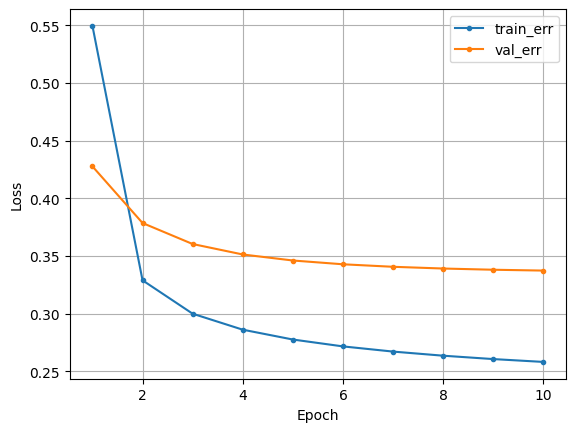

In [24]:
dl_learning_curve(tr_loss_list, val_loss_list)

### (3) 모델 평가

In [25]:
_, pred = evaluate(x_test, y_test, model, loss_fn, device)
pred[:5]

tensor([[ -2.3957,  -7.5368,  -2.7871,   3.8384,  -3.5253,   3.2929,  -8.3723,  -7.1073,  -1.2936,  -2.9722],
        [ -4.6172, -12.7571,  -2.0709,  -1.0853,   2.3666,  -1.9081,  -4.3683,  -1.9253,   2.1538,   2.8876],
        [ -6.0880, -16.2210,  -7.7517,  -5.3807,   2.7528,  -5.5009,  -7.9099,   0.8966,   1.9936,   7.9824],
        [ -6.8069, -12.0147,  -5.3193,  -3.7108,  -6.4666,   0.3293,  -9.9655,  -8.9882,   8.4820,   0.8462],
        [ -1.8883, -18.0607,  -4.8518,  -8.3028,   7.6092,  -2.9584,  -2.1439,  -2.7222,  -1.1368,   0.9611]], device='cuda:0')

* 예측결과를 각 클래스별 확률값으로 변환 : nn.functional.softmax()
* 가장 확률이 높은 클래스 찾기 : np.argmax()

In [26]:
pred = nn.functional.softmax(pred, dim=1)
pred = np.argmax(pred.cpu().numpy(), axis = 1)
pred

array([3, 9, 9, ..., 4, 5, 6])

* confusion matrix

In [27]:
cm = confusion_matrix(y_test.numpy(), pred)
cm

array([[512,   0,   0,   2,   0,   2,   3,   1,   0,   0],
       [  0, 553,   1,   0,   0,   1,   1,   1,   7,   0],
       [  2,   4, 455,   3,   2,   2,   8,   4,  20,   2],
       [  3,   0,   9, 467,   0,  10,   1,   0,  15,   5],
       [  1,   1,   1,   0, 456,   0,   3,   2,   6,  12],
       [  3,   1,   0,   9,   3, 403,   8,   0,   9,   0],
       [  3,   0,   1,   1,   2,   4, 485,   0,   0,   0],
       [  0,   1,   9,   1,   0,   0,   0, 495,   0,  10],
       [  2,   4,   0,   2,   2,  10,   7,   2, 452,   4],
       [  5,   0,   0,   3,   4,   3,   0,   8,   2, 464]])

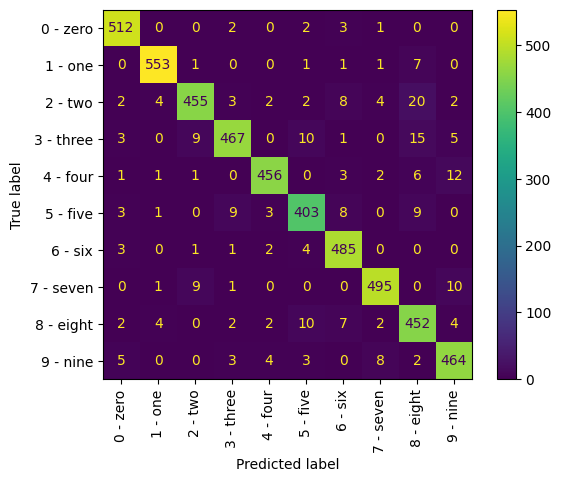

In [28]:
# confusion matrix 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = train_dataset.classes)
disp.plot()
plt.xticks(rotation=90)
plt.show()

* classification_report

In [29]:
print(classification_report(y_test.numpy(), pred))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       520
           1       0.98      0.98      0.98       564
           2       0.96      0.91      0.93       502
           3       0.96      0.92      0.94       510
           4       0.97      0.95      0.96       482
           5       0.93      0.92      0.93       436
           6       0.94      0.98      0.96       496
           7       0.96      0.96      0.96       516
           8       0.88      0.93      0.91       485
           9       0.93      0.95      0.94       489

    accuracy                           0.95      5000
   macro avg       0.95      0.95      0.95      5000
weighted avg       0.95      0.95      0.95      5000



## **4.모델링2 : 은닉층 추가**
* 지금부터는 여러분이 수행합니다.
* 은닉층이 수와 노드 수를 조절하며 모델을 설계하고, 학습시켜 봅시다.
* 단, 은닉층의 활성화 함수는 ReLU, epoch는 20 이내로 설정합시다.


### (1) 모델 선언

In [30]:
model = nn.Sequential(nn.Flatten(),
                      nn.Linear(28*28, 100),
                      nn.ReLU(),
                      nn.Linear(100,50),
                      nn.ReLU(),
                      nn.Linear(50,10)
                      ).to(device)
print(model)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=100, bias=True)
  (2): ReLU()
  (3): Linear(in_features=100, out_features=50, bias=True)
  (4): ReLU()
  (5): Linear(in_features=50, out_features=10, bias=True)
)


* Loss function과 Optimizer

In [31]:
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

### (2) 학습

In [32]:
epochs = 10
tr_loss_list, val_loss_list = [], []

for t in range(epochs):
    tr_loss = train(train_dataloader, model, loss_fn, optimizer, device)
    val_loss,_ = evaluate(x_val, y_val, model, loss_fn, device)

    # 리스트에 loss 추가 --> learning curve 그리기 위해.
    tr_loss_list.append(tr_loss)
    val_loss_list.append(val_loss)

    print(f"Epoch {t+1}, train loss : {tr_loss:4f}, val loss : {val_loss:4f}")

Epoch 1, train loss : 0.375352, val loss : 0.256773
Epoch 2, train loss : 0.163896, val loss : 0.174952
Epoch 3, train loss : 0.116521, val loss : 0.138104
Epoch 4, train loss : 0.089100, val loss : 0.125044
Epoch 5, train loss : 0.069893, val loss : 0.122742
Epoch 6, train loss : 0.055476, val loss : 0.127375
Epoch 7, train loss : 0.044193, val loss : 0.129545
Epoch 8, train loss : 0.035208, val loss : 0.177379
Epoch 9, train loss : 0.028875, val loss : 0.114765
Epoch 10, train loss : 0.024233, val loss : 0.130858


* 학습 곡선

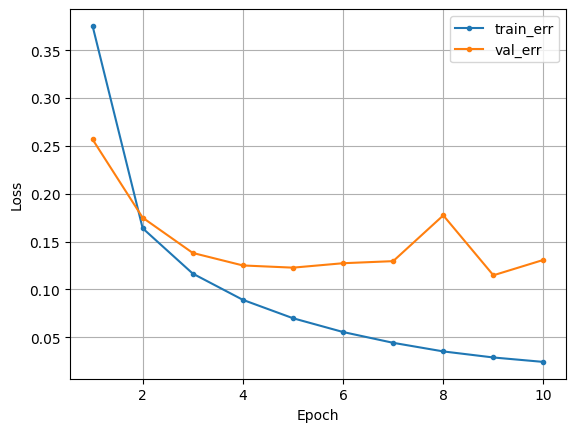

In [33]:
dl_learning_curve(tr_loss_list, val_loss_list)

### (3) 모델 평가

In [34]:
_, pred = evaluate(x_test, y_test, model, loss_fn, device)
pred[:5]

tensor([[-17.7737,  -9.4694,  -6.9053,  16.9963, -13.6098,  -6.0071, -23.7832,  -8.7761,  -3.7205, -10.1713],
        [-11.8083, -15.2421,  -6.0428,  -2.8356,  -3.1877,  -7.8248, -20.4717,  -1.1879,  -0.9136,   9.7360],
        [-13.3073, -10.3333,  -7.6436,  -1.0226,  -1.6565, -15.7160, -26.9940,   1.0557,  -5.1706,  13.3605],
        [ -9.4710, -14.5317,  -4.3143,  -3.4014, -15.5943,  -7.0578, -17.4579, -11.4700,  16.4862,  -2.2648],
        [-14.5880, -10.3159,  -4.0528, -11.4652,  19.0309, -12.2476, -11.8534,  -4.7080,  -7.7481,  -1.6653]], device='cuda:0')

* 예측결과를 각 클래스별 확률값으로 변환 : nn.functional.softmax()
* 가장 확률이 높은 클래스 찾기 : np.argmax()

In [35]:
pred = nn.functional.softmax(pred, dim=1)
pred = np.argmax(pred.cpu().numpy(), axis = 1)
pred

array([3, 9, 9, ..., 4, 5, 6])

* confusion matrix

In [36]:
cm = confusion_matrix(y_test.numpy(), pred)
cm

array([[514,   0,   0,   2,   1,   1,   1,   0,   0,   1],
       [  0, 558,   0,   0,   0,   0,   2,   0,   3,   1],
       [  5,   0, 490,   0,   3,   0,   1,   2,   1,   0],
       [  0,   0,   2, 501,   0,   2,   0,   1,   2,   2],
       [  0,   0,   0,   1, 476,   2,   0,   1,   1,   1],
       [  1,   0,   0,   6,   0, 427,   1,   0,   0,   1],
       [  0,   0,   1,   1,   3,   3, 488,   0,   0,   0],
       [  0,   1,   4,   1,   0,   0,   0, 508,   0,   2],
       [  2,   0,   1,   3,   2,   3,   2,   2, 469,   1],
       [  0,   0,   0,   1,   1,   0,   0,   2,   0, 485]])

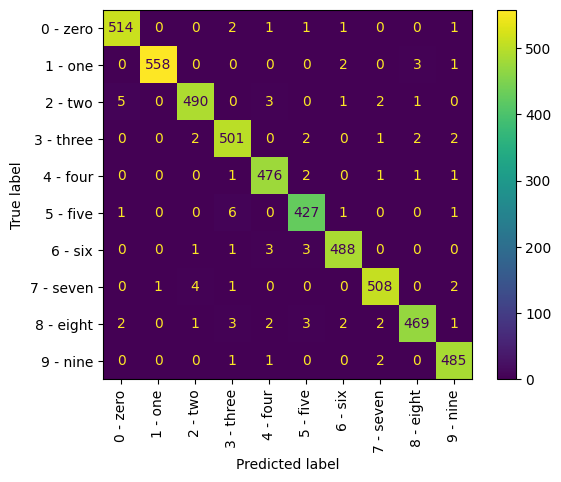

In [37]:
# confusion matrix 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = train_dataset.classes)
disp.plot()
plt.xticks(rotation=90)
plt.show()

* classification_report

In [38]:
print(classification_report(y_test.numpy(), pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       520
           1       1.00      0.99      0.99       564
           2       0.98      0.98      0.98       502
           3       0.97      0.98      0.98       510
           4       0.98      0.99      0.98       482
           5       0.97      0.98      0.98       436
           6       0.99      0.98      0.98       496
           7       0.98      0.98      0.98       516
           8       0.99      0.97      0.98       485
           9       0.98      0.99      0.99       489

    accuracy                           0.98      5000
   macro avg       0.98      0.98      0.98      5000
weighted avg       0.98      0.98      0.98      5000

